###### 參考資料：
1. [AE in keras]( https://blog.keras.io/building-autoencoders-in-keras.html)
- [Autoencoder 自编码](https://morvanzhou.github.io/tutorials/machine-learning/keras/2-6-autoencoder/)
- PSNR、SSIM:
 - [skimage.measure.compare_psnr](http://scikit-image.org/docs/dev/api/skimage.measure.html)
 - [skimage.measure.compare_ssim](http://scikit-image.org/docs/dev/api/skimage.measure.html)
- [28 Jupyter Notebook tips, tricks, and shortcuts:](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/)

###### 規則補充
- 52張拿出以下8張當test imags, 其餘為training images: 
- 紅桃 6, J; 黑桃 7, Q; 鑽石 8, K; 梅花 9, Q
 - => 32、37、46、50、21、26、9、12
- input 採PCA 60% 結果; 
- 要寫Autoencoder 和Autoencoder+Gan 兩種程式, 比較結果.

In [0]:
import numpy as np
import os

### 檔案連結

In [0]:
from google.colab import drive

In [3]:
# 連接雲端
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
mainFolder = "/content/gdrive/My Drive/Colab Notebooks/0104_AE-GAN/"

In [5]:
os.listdir(mainFolder)

['poker_data_PCA60',
 'poker_data_org',
 'poker_data_PCA80',
 'org.npy',
 'pca60.npy',
 '0114_00_makeDataNPY.ipynb',
 'output0115_AE',
 '0114_GAN.ipynb',
 'AE.log',
 '0114_AE.ipynb']

### LOG

In [0]:
def CheckFolder(outputFolder):
    print(outputFolder, ":", end = "")
    if ( os.path.isdir(outputFolder)):
        print("Directory exists~")
        return True
    else:
        print("Directory not found!")
        os.mkdir(outputFolder)
        if ( os.path.isdir(outputFolder)):
            print("CREAT DONE: Directory exists!")
            return True
    return False

In [0]:
from pytz import timezone
from datetime import datetime
class DataLog:
    def __init__(self, timezone_local = "Asia/Taipei" ):
        # 
        self.SetFolder("./", txtName = "tmp")
        print("Remember Set Folder")
        # timeaone set #TPE 以這樣的變數可能要改一下變數名稱
        self.tpe = timezone(timezone_local)
        return
    def SetFolder(self, folder, txtName = None, file_extension = ".txt"):
        if folder[-1] != "/":
            folder += "/"
        CheckFolder(folder)
        # name set
        self.folder = folder
        if txtName is None:
            self.txtName = folder.rsplit("/", 2)[1] + file_extension
        elif txtName.rsplit(".", 1)[-1] != file_extension:
            self.txtName = txtName + file_extension
        else:
            self.txtName = txtName
        return
    def GetTime_TPE(self):
        utcnow = datetime.utcnow()
        return self.tpe.fromutc(utcnow).timetuple()
    def WriteLog(self, inputString):
        with open(self.folder + self.txtName, "a") as f:
            f.write(inputString + "\n")
        return inputString
    def SetTimeLog(self, eventTitle):
        time_now = self.GetTime_TPE()
#         self.WriteLog(eventTitle + ": " + "-".join([str(i) for i in time_now[0:3]]) + " " +":".join([str(i) for i in time_now[3:5]]))
        self.WriteLog("%s : %4d-%02d-%02d %02d:%02d"%(eventTitle, time_now[0], time_now[1], time_now[2], time_now[3], time_now[4]))
        return

In [8]:
OWNLog = DataLog()

./ :Directory exists~
Remember Set Folder


In [9]:
time_now = OWNLog.GetTime_TPE()
OWNLog.SetFolder(mainFolder, txtName = "AE", file_extension = ".log")

/content/gdrive/My Drive/Colab Notebooks/0104_AE-GAN/ :Directory exists~


In [0]:
OWNLog.SetTimeLog("START_ALL")

In [11]:
os.listdir(mainFolder)

['poker_data_PCA60',
 'poker_data_org',
 'poker_data_PCA80',
 'org.npy',
 'pca60.npy',
 '0114_00_makeDataNPY.ipynb',
 'output0115_AE',
 '0114_GAN.ipynb',
 'AE.log',
 '0114_AE.ipynb']

# 原程式

  ## 開頭

###### 匯入

In [0]:
# 時間計算
import time 
# 數值運算
import numpy as np
# 圖片輸出用
from matplotlib import pyplot as plt
from cv2 import imwrite 
# 結果運算用
from skimage.measure import compare_psnr, compare_ssim 

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
# from keras.models import load_model

Using TensorFlow backend.


###### 開始

In [0]:
_startTime = time.time()

In [0]:
OWNLog.SetTimeLog("START_MAIN")

##### 函數

###### 函數 - 測試用

In [0]:
def CheckType(intVar):
    print("max:",   intVar.max())
    print("min:",   intVar.min())
    print("shape:", intVar.shape)
    print("type:",  intVar.dtype)
    return

###### 函數 - 輸出用

In [0]:
def ResultImgShow(inputImg1, inputImg2 = None, modelName = "MODELNAME", strImgLabel = "TMP"):
    # 輸出參數設置
    img_amount1 = len(inputImg1)
    if not inputImg2 is None:
        img_amount2 = len(inputImg2)
    cols_output = 4
    rows_output1 = img_amount1//cols_output; print(rows_output1);
    if not inputImg2 is None:
        rows_output2 = img_amount2//cols_output; print(rows_output2);
#     if rows_output > cols_output:
#         rows_output = cols_output
    # 輸出設置 - 水平堆疊再垂直堆疊
    ## v - 初始
    img_h = inputImg1[0]
    for i in range(1, cols_output):
        img_tmp = inputImg1[i]
        img_h = np.hstack((img_h, img_tmp))
    img_v = img_h.copy()
    ## v - Loop - inputImg1
    for j in range(1, rows_output1): #在 2
        ## h - 初始
        img_h = inputImg1[j * cols_output]
        ## h - Loop
        for i in range(1, cols_output):
            img_tmp = inputImg1[j * cols_output + i]
            img_h = np.hstack((img_h, img_tmp))
        img_v = np.vstack((img_v, img_h))
    
    if not inputImg2 is None:
        ## v - Loop - inputImg2
        for j in range(0, rows_output2):
            ## h - 初始
            img_h = inputImg2[j * cols_output]
            ## h - Loop
            for i in range(1, cols_output):
                img_tmp = inputImg2[j * cols_output + i]
                img_h = np.hstack((img_h, img_tmp))
            img_v = np.vstack((img_v, img_h))
    
    # 顯示 與 存取
    imwrite(modelName.split(".")[0] +"_"+ strImgLabel+ ".png", img_v)
    plt.imshow(img_v, cmap = "gray")
#     plt.savefig(model_name.split(".")[0] +"_"+ strImgLabel+ ".png")
    plt.show()
    plt.close()
    return

###### 函數 - 計算誤差

In [0]:
def PSNR_ALL(testData, truthData, strImgLabel = "TMP", boolTest = False):
    """ """
#     dataAmount = 1 if testData.shape < 3 else testData.shape[0]
#     if testData.shape < 3:
#         dataAmount = 1
#     else:
    dataAmount = testData.shape[0]
    psnrSum_test = 0
    for i in range(dataAmount):
        groundTruth   = truthData[i, :,:]
        predictResult = testData[i, :,:]
        psnrTmp = float(compare_psnr(groundTruth, predictResult))
        psnrSum_test += psnrTmp
    psnrSum_test /= dataAmount
    print(strImgLabel, "PSNR:", psnrSum_test)
    return psnrSum_test

In [0]:
def SSIM_ALL(testData, truthData, strImgLabel = "TMP", boolTest = False):
    dataAmount = testData.shape[0]
    ssimSum_test = 0
    for i in range(dataAmount):
        groundTruth   = truthData[i, :,:]
        predictResult = testData[i, :,:]
        ssimTmp = float(compare_ssim(groundTruth, predictResult))
        ssimSum_test += ssimTmp
    ssimSum_test /= dataAmount
    print(strImgLabel, "SSIM:", ssimSum_test)
    return ssimSum_test

###### 函數 - 預處理與後處理

In [0]:
def DataPreProcess(inputData, img_rows = 28, img_cols = 28):
    outputData = inputData.reshape(inputData.shape[0], img_rows * img_cols)
    outputData = outputData.astype('float32') /255 -0.5
    outputData *= 2
    return outputData
def DataRecovery(inputData, img_rows = 28, img_cols = 28):
    outputData = ((inputData /2)+0.5) * 255
    outputData = outputData.reshape((outputData.shape[0], img_rows, img_cols))
    outputData = outputData.astype('uint8')
    return outputData

## 主程式

In [0]:
class AE:
    def __init__(self, img_rows = 96, img_cols = 71, channels = 1):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.shape = (self.img_rows, self.img_cols, self.channels)
                
        self.E = self.__encoder_complex()
#         self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        self.D = self.__dencoder_complex()
#         self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        
        self.stacked_AE = self.__stacked_E_D()
        self.stacked_AE.compile(optimizer='adam', loss='mse')
        return
    
    def __encoder_complex(self):
        model = Sequential()
        model.add(Dense(1500, activation='relu', input_shape=(6816,))) # img_rows * img_cols
        model.add(Dense(375, activation='relu')) 
        model.add(Dense(50)) 
#         model.summary()
        return model 
    
    def __dencoder_complex(self):
        model = Sequential()
        model.add(Dense(375, activation='relu')) 
        model.add(Dense(1500, activation='relu')) 
        model.add(Dense(6816, activation='tanh'))  # img_rows * img_cols
#         model.summary()
        return model 
    
    def __stacked_E_D(self):
#         self.D.trainable = False
        
        model = Sequential()
        model.add(self.E)
        model.add(self.D)
        
        return model # model
    
    def Train(self, x_train_noise, x_train_org, batch_size = 13, epochs = 500):
        history_complex = self.stacked_AE.fit(x_train_noise, x_train_org, # 訓練資料、結果比對資料
                    batch_size=batch_size, 
                    epochs=epochs)
        return self.stacked_AE
    
    def DataPreProcess(self, inputData):#,, img_rows = 28, img_cols = 28):
        outputData = inputData.reshape(inputData.shape[0], self.img_rows * self.img_cols)
        outputData = outputData.astype('float32') /255 -0.5
        outputData *= 2
        return outputData
    def DataRecovery(self, inputData):#, img_rows = 28, img_cols = 28):
        outputData = ((inputData /2)+0.5) * 255
        outputData = outputData.reshape((outputData.shape[0], self.img_rows, self.img_cols))
        outputData = outputData.astype('uint8')
        return outputData
    

###### 參數設置

In [22]:
outputFolder = mainFolder + "output0115_AE/"
CheckFolder(outputFolder);
batch_size = 13 
# num_classes = 10
epochs = 4000
# input image dimensions
img_rows, img_cols = 96, 71

/content/gdrive/My Drive/Colab Notebooks/0104_AE-GAN/output0115_AE/ :Directory exists~


##### 讀取訓練資料
- 利用完整沒雜訊的資料進行訓練 。
- 只取用圖像，不取標籤。

In [0]:
OWNLog.SetTimeLog("START_READ_DATA")

In [0]:
datasetFolder = mainFolder

In [0]:
dataSetName_org = "org.npy"
dataSetName_noise = "pca60.npy"

11
2


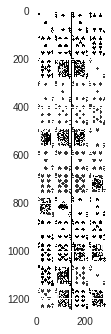

In [26]:
f = np.load(datasetFolder + dataSetName_org).item()
x_train_org, x_test_org = np.array(f['train']), np.array(f['test'])
del f
ResultImgShow(x_train_org, x_test_org, outputFolder + "CLEAN-IN", strImgLabel = "ORIGIN")

In [0]:
f = np.load(datasetFolder + dataSetName_noise).item()
x_train_noise, x_test_noise = np.array(f['train']), np.array(f['test'])
del f

11
2


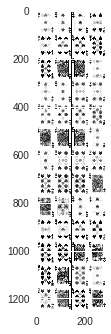

In [28]:
ResultImgShow(x_train_noise, x_test_noise, outputFolder + "NOISE-IN", strImgLabel = "ORIGIN")

###### 預處理
- [shuffle](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.shuffle.html)

In [0]:
OWNLog.SetTimeLog("START_PROCESS_DATA")

In [0]:
arrArgTrain = np.arange(x_train_noise.shape[0])
np.random.shuffle(arrArgTrain)
x_train_org = x_train_org[arrArgTrain]
x_train_noise = x_train_noise[arrArgTrain]

In [0]:
ae = AE()

In [32]:
x_train_noise = ae.DataPreProcess(x_train_noise)
print(x_train_noise.shape[0], 'train samples', "in", x_train_noise.shape)
x_test_noise = ae.DataPreProcess(x_test_noise)
print(x_test_noise.shape[0], 'test samples', "in", x_test_noise.shape)

44 train samples in (44, 6816)
8 test samples in (8, 6816)


In [0]:
x_train_org = ae.DataPreProcess(x_train_org)
x_test_org = ae.DataPreProcess(x_test_org)

##### 訓練
- [fit verbose- 中文](https://keras-cn.readthedocs.io/en/latest/models/model/)
- [fit verbose- 原文](https://keras.io/models/sequential/)

In [0]:
OWNLog.SetTimeLog("START_TRAIN")

In [35]:
autoencoder_complex = ae.Train(x_train_noise, x_train_org, batch_size = batch_size, epochs = epochs)

Epoch 1/4000
44/44 [==============================] - 3s 62ms/step - loss: 0.7023
Epoch 2/4000
44/44 [==============================] - 0s 3ms/step - loss: 0.3473
Epoch 3/4000
44/44 [==============================] - 0s 3ms/step - loss: 0.2698
Epoch 4/4000
44/44 [==============================] - 0s 3ms/step - loss: 0.2200
Epoch 5/4000
44/44 [==============================] - 0s 3ms/step - loss: 0.2095
Epoch 6/4000
44/44 [==============================] - 0s 3ms/step - loss: 0.1927
Epoch 7/4000
44/44 [==============================] - 0s 3ms/step - loss: 0.1915
Epoch 8/4000
44/44 [==============================] - 0s 3ms/step - loss: 0.1862
Epoch 9/4000
44/44 [==============================] - 0s 3ms/step - loss: 0.1719
Epoch 10/4000
44/44 [==============================] - 0s 3ms/step - loss: 0.1545
Epoch 11/4000
44/44 [==============================] - 0s 3ms/step - loss: 0.1420
Epoch 12/4000
44/44 [==============================] - 0s 3ms/step - loss: 0.1337
Epoch 13/4000
44/44 [===

###### 儲存模組

In [0]:
OWNLog.SetTimeLog("DONE_TRAIN_AND_SAVE")

In [0]:
# model_name_complex = outputFolder + "AE_model_complex"+ \
#                     "_e"+str(epochs)+"_b" + str(batch_size) + \
#                     ".h5"
# #                     "_" + "-".join([str(i) for i in time.localtime()[0:5]]) +\
# autoencoder_complex.save(model_name_complex)

#### 模組 - 使用與輸出

In [0]:
OWNLog.SetTimeLog("START_PREDICT")

In [0]:
decodeImg_test = autoencoder_complex.predict(x_test_noise)
decodeImg_test = ae.DataRecovery(decodeImg_test)
x_test_org = ae.DataRecovery(x_test_org)

In [40]:
ResultImgShow(decodeImg_test, modelName = model_name_complex, strImgLabel = "AFTER");

NameError: ignored

#### 計算誤差

In [0]:
OWNLog.SetTimeLog("COMPUTE_PSNR_SSIM")

In [42]:
intPSNR = PSNR_ALL(decodeImg_test, x_test_org, "TEST")
print(OWNLog.WriteLog("PSNR: %.4f"%(intPSNR)))

TEST PSNR: 12.305760203495979
PSNR: 12.3058


In [43]:
intSSIM = SSIM_ALL(decodeImg_test, x_test_org, "TEST")
print(OWNLog.WriteLog("SSIM: %.4f"%(intSSIM)))

TEST SSIM: 0.6820276064754003
SSIM: 0.6820


#### 模組儲存
用誤差當檔名

In [0]:
model_name_complex = outputFolder + "AE_model_complex_e%d_b%d_%.1f-%.1f.h5"%(epochs, batch_size, intPSNR, intSSIM)
#                     "_" + "-".join([str(i) for i in time.localtime()[0:5]]) +\
autoencoder_complex.save(model_name_complex)

# 結束

In [0]:
del autoencoder_complex

In [0]:
OWNLog.SetTimeLog("DONE======")